# Starting point
## Maximum tidal amplitude compared against TPXO 7.2 solution
What I try do achive is a comparison of maximum tidal amplitude from ROMS against the TPXO7.2 solution (provides forcing for ROMS). To do so, I compare ROMS maximum sea surface height anomaly from a hourly record of 14 days against the summation of the amplitudes over all (8) constituents from the forcing file. 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

src_dir = os.environ.get('srcdir')
print(src_dir)

sys.path.append(src_dir)

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

%aimport features.grid_ttide
from features.grid_ttide import grid_ttide

/home/ubuntu/bigStick/tidal_melting/src


In [2]:
file_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','ocean_his_hourly.nc')
ds_ref = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

In [ ]:
# calculate maximum anomaly of the free surface height compared to the 14 day mean
ref_maxAmpl = ds_ref.zeta.max('ocean_time')-ds_ref.zeta.mean('ocean_time')

In [2]:
# load tpxo forcing amplitude and phase information as Xarray dataset
tpxo_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_tds_large.nc')
dsf = xr.open_mfdataset(tpxo_path)

# calculate the superposition of amplitudes of all constituents (max tidal amplitude possible)
tpxo_maxAmpl = dsf.sum('tide_period')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


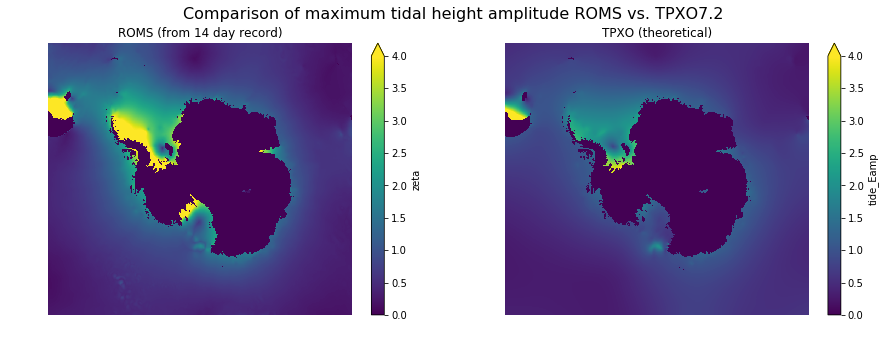

In [3]:
# plot both next to each other with same colorbounds
plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,5))
fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
ref_maxAmpl.fillna(0).plot(ax=ax1,vmax=4)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_maxAmpl.tide_Eamp.plot(ax=ax2,vmax=4)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()

... Roms gets about two times to high under the big ice shelves. Since the height looks ok everywhere else, this might be related to the kelvin waves. Two ideas to fix this:
1. no forcing on the continental shelf
2. increase bottom/ice shelf drag, high resolution might help

## Comparison of M2 and O1 amplitude maps
(others violate Rayleigh condition with just 14 day record) 
Apply t_tide tidal harmonic analysis on every grid point and fill O1 and M2 amplitude maps in Xarray dataset.
First define the function

In [ ]:
ta.grid_ttide(ds_ref,ds_ref)

then apply to dataset.

In [20]:
grid_lr_path =  os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_grd_large.nc')
grid_lr = xr.open_mfdataset(grid_lr_path)
ds_ref = ta.grid_ttide(ds_ref,grid_lr,res=50)

setting up the new fields  ['amp', 'amp_err', 'phase', 'phase_err']  for  ['O1', 'M2']
applying t_tide to every  50 th cell


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating intermediate cells and mask land


Plot against TPXO O1 and M2 amplitude maps

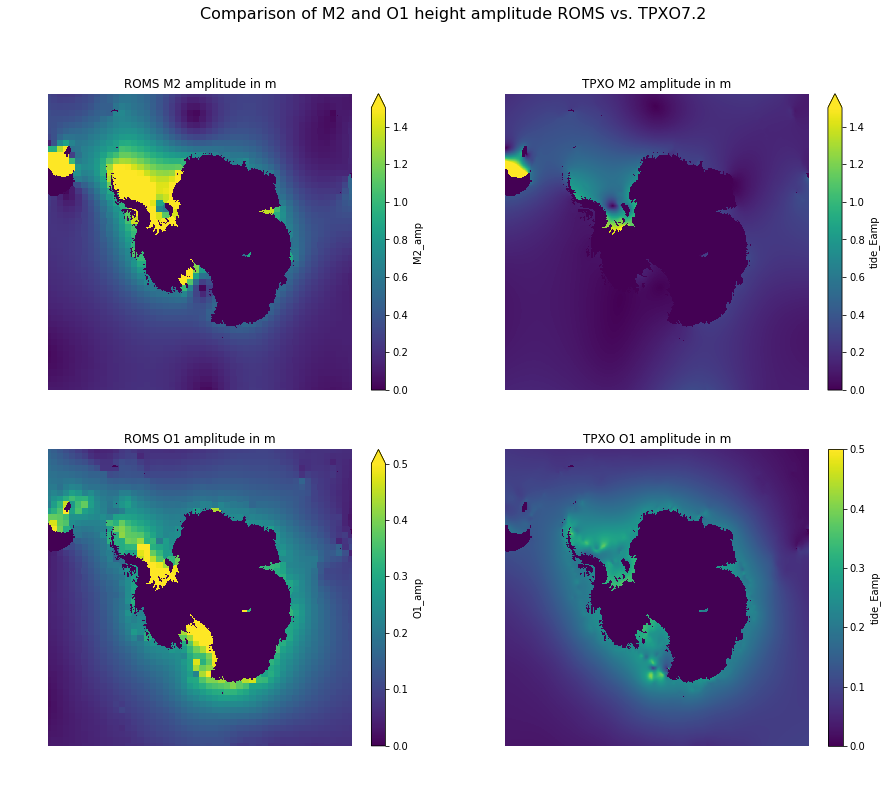

In [21]:
plt.close('all')
fig,axes = plt.subplots(2,2,figsize=(15,12))
ax1,ax2,ax3,ax4 = axes.flatten()
fig.suptitle('Comparison of M2 and O1 height amplitude ROMS vs. TPXO7.2',fontsize=16)
ds_ref.M2_amp.fillna(0).plot(ax=ax1,vmax=1.5)
ax1.set_title('ROMS M2 amplitude in m')
ax1.axis('off')
dsf.tide_Eamp[0].plot(ax=ax2,vmax=1.5)
ax2.set_title('TPXO M2 amplitude in m')
ax2.axis('off')
ds_ref.O1_amp.fillna(0).plot(ax=ax3,vmax=0.5)
ax3.set_title('ROMS O1 amplitude in m')
ax3.axis('off')
dsf.tide_Eamp[5].plot(ax=ax4,vmax=0.5)
ax4.set_title('TPXO O1 amplitude in m')
ax4.axis('off')
plt.show()

... both are unacceptable to high.

# Tuning: No forcing under the ice shelves
Dave suggested that the to high tides might come from some model amplification under the ice shelves. Therefore I look at an experiment, without tidal surface forcing where ice shelf is present.
## Generating the tidal mask

In [ ]:
#mask tidal forcing
pott_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)
Pamp_masked = pott_ds.tide_Pamp.where(grid_lr.zice.values == 0.0 ,0.0)
plt.close()
Pamp_masked[2].plot()
plt.show()

## Effect on max surface height anomaly
plot against tpxo as before, but define function for later plots

In [7]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_0006.nc')
ds_tm = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
tm_maxAmpl = ds_tm.zeta[336:].max('ocean_time')-ds_tm.zeta[336:].mean('ocean_time')

In [4]:
def plot_max_ampl(case_max_ampl_da,case_str,ref_max_ampl,ref_str):
    plt.clf()
    fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
    fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
    
    ref_max_ampl.fillna(0).plot(ax=ax1,vmax=4)
    ax1.set_title(ref_str+' [m]')
    ax1.axis('off')
    
    case_max_ampl_da.fillna(0).plot(ax=ax2,vmax=4)
    ax2.set_title(case_str+ ' [m]')
    ax2.axis('off')
    
    tpxo_maxAmpl.tide_Eamp.plot(ax=ax3,vmax=4)
    ax3.set_title('TPXO (theoretical)')
    ax3.axis('off')
    
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


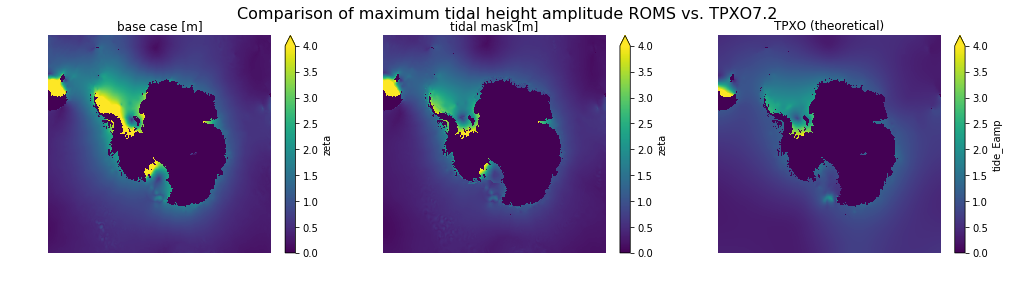

In [9]:
plot_max_ampl(tm_maxAmpl,'tidal mask',ref_maxAmpl,'base case')

... this looks a lot better, though its still ssh amplitudes are still to high in the shallow areas under the ice shelves.
## M2 and O1 maps

In [10]:
ds_tm = grid_ttide(ds_tm,grid_lr,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


In [5]:
# load tpxo forcing amplitude and phase information as Xarray dataset
def plot_M2O1(case_ds,case_str,ds_ref,ref_str):
    plt.close('all')
    fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(17,8))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
    fig.suptitle('Comparison of M2 and O1 height amplitude',fontsize=16)

    ds_ref.M2_ampl.fillna(0).plot(ax=ax1,vmax=1.5)
    ax1.set_title(ref_str+' [m]')
    ax1.axis('off')

    case_ds.M2_ampl.fillna(0).plot(ax=ax2,vmax=1.5)
    ax2.set_title(case_str +' [m]')
    ax2.axis('off')

    dsf.tide_Eamp[0].plot(ax=ax3,vmax=1.5)
    ax3.set_title('TPXO M2 amplitude in m')
    ax3.axis('off')


    ds_ref.O1_ampl.fillna(0).plot(ax=ax4,vmax=0.5)
    ax4.set_title(ref_str+' [m]')
    ax4.axis('off')

    case_ds.O1_ampl.fillna(0).plot(ax=ax5,vmax=0.5)
    ax5.set_title(case_str+' [m]')
    ax5.axis('off')

    dsf.tide_Eamp[5].plot(ax=ax6,vmax=0.5)
    ax6.set_title('TPXO O1 amplitude in m')
    ax6.axis('off')

    plt.show()

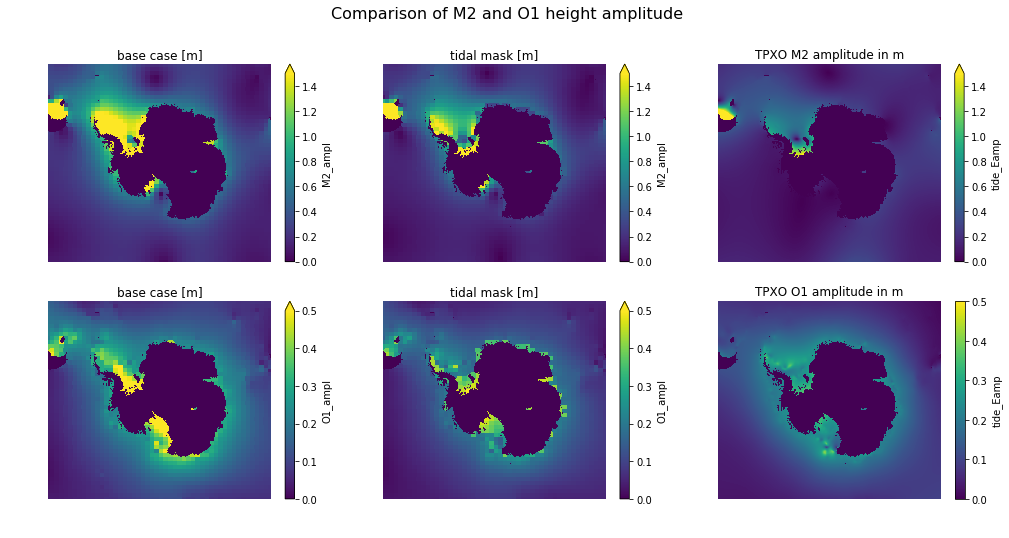

In [35]:
plot_M2O1(ds_tm,'tidal mask',ds_ref,'base case')

... seems like we get a big step at the mask boundary.

# 5x Drag coefficient
Ramping up the drag coefficent from 0.003 to 0.015 to represent conversion to internal tides, which is not present in 10 km model run.

In [13]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_5xCd_0006.nc')
ds_Cd = xr.open_dataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
Cd_maxAmpl = ds_Cd.zeta[336:].max('ocean_time')-ds_Cd.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


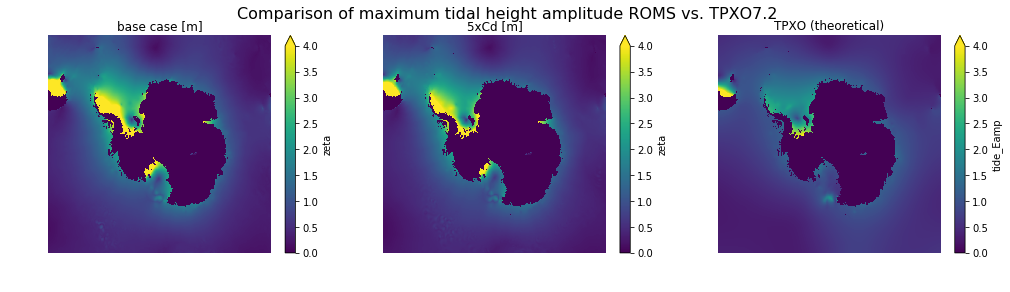

In [14]:
plot_max_ampl(Cd_maxAmpl,'5xCd',ref_maxAmpl,'base case')

... visible, but small decrease in max amplitude.
# 2x viscosity
Ramping up the visc2 from 500 m^2/s to 1000 m^2/s.

In [15]:
#look at results
import os
import xarray as xr
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_2xVisc2_0006.nc')
ds_Vi = xr.open_dataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
Vi_maxAmpl = ds_Vi.zeta[336:].max('ocean_time')-ds_Vi.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


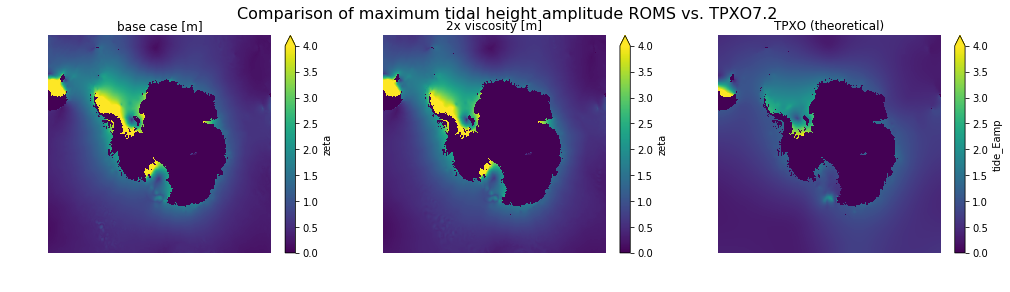

In [16]:
plot_max_ampl(Vi_maxAmpl,'2x viscosity',ref_maxAmpl,'base case')

... almost no impact.
# Mask shallow areas
Since bathymetry has such a big impact on tides, maybe our artificial deepening at the grounding lines create the bias.   
Masking shallow areas (including all artificially deepened cells) by setting mask_rho == 0 where wct <= 50 m.

In [17]:
#look at results
import os
import xarray as xr
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_ms_0006.nc')
ds_ms = xr.open_dataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
ms_maxAmpl = ds_ms.zeta[336:].max('ocean_time')-ds_ms.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


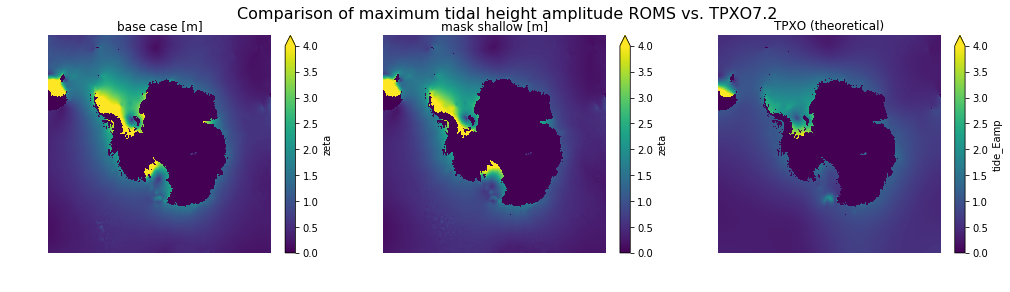

In [18]:
plot_max_ampl(ms_maxAmpl,'mask shallow',ref_maxAmpl,'base case')

... a bit better in the Weddell Sea and Amery. However in the Ross sea it seems just to shift the high amplitudes further in the direction of the kelvin wave propagation.
... more ideas would be trying a different vertical mixing scheme as recommended by Robin Robertson (MY and some GLS) and looking at the impact of increased resolution.

# 2x horizontal resolution
By increasing the horizontal resolution from 10km to 5km we hope to lose energy into baroclinic tides, which we don't resolve withthe coarse grid. Also better representation of bathymetry and ice draft, less smoothing and artificial deepening to only 30m water column thickness might have an impact. 

In [7]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom5','ocean_his_0002.nc')
ds_hr = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
hr_maxAmpl = ds_hr.zeta.max('ocean_time')-ds_hr.zeta.mean('ocean_time')

### Max tidal height amplitude

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


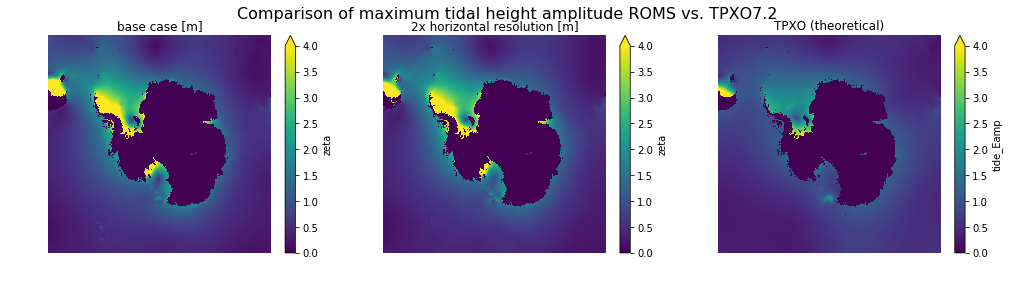

In [8]:
plot_max_ampl(hr_maxAmpl,'2x horizontal resolution',ref_maxAmpl,'base case')

### M2 O1 height amplitudes

In [9]:
ds_hr = grid_ttide(ds_hr,ds_hr,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


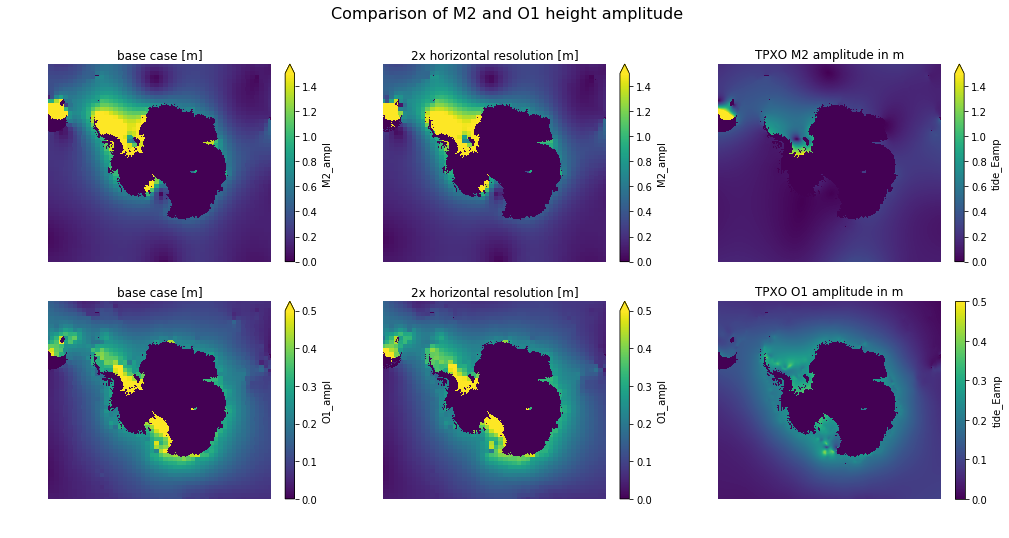

In [10]:
plot_M2O1(ds_hr,'2x horizontal resolution',ds_ref,'base case')

# 2x horizontal resolution and MY25 vertical mixing scheme
Following advice from Robin Roberston, I've changed the vertical mixing from LMD to MY. However, we expect MY to mix less than LMD and therefore possibly dissipate less energy?

In [11]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom5_MY','ocean_his_0002.nc')
ds_my = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
my_maxAmpl = ds_my.zeta[:].max('ocean_time')-ds_my.zeta[:].mean('ocean_time')

### Max tidal height amplitude

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


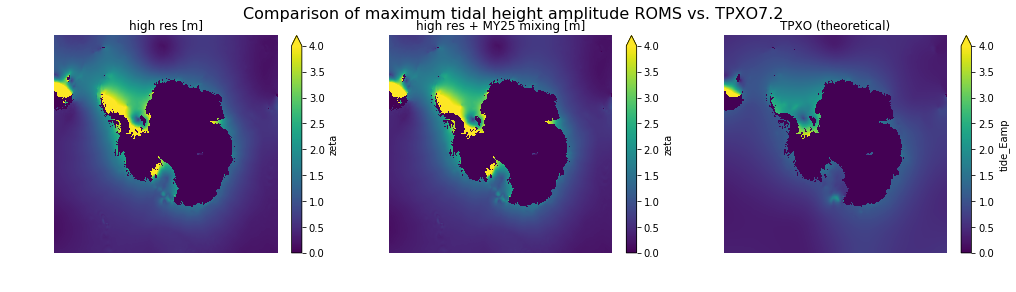

In [12]:
plot_max_ampl(my_maxAmpl,'high res + MY25 mixing',hr_maxAmpl,'high res')

### M2 O1 height amplitudes

In [13]:
ds_my = grid_ttide(ds_my,ds_my,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


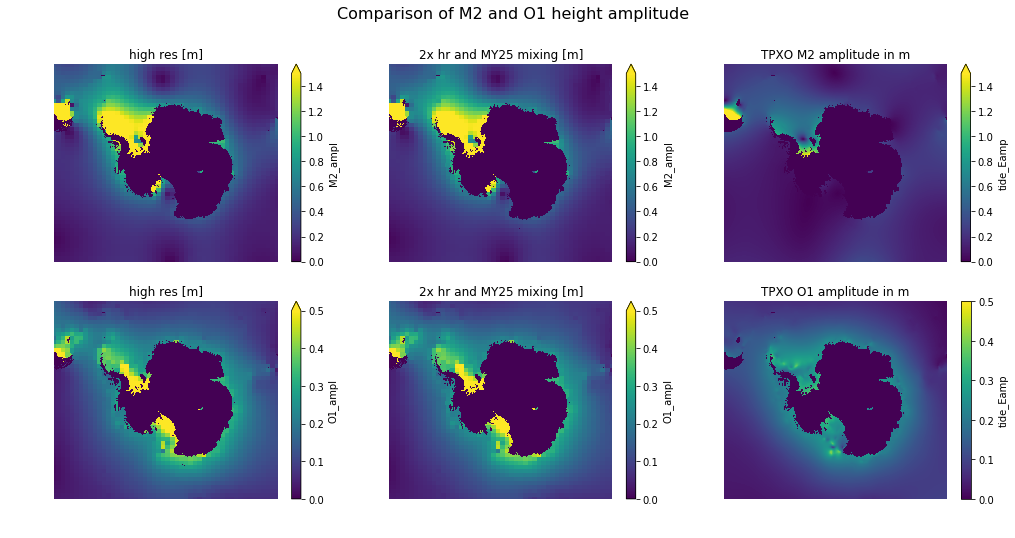

In [14]:
plot_M2O1(ds_my,'2x hr and MY25 mixing',ds_hr,'high res')

# 2x horizontal resolution and no topography smoothing
Following Robins papaers, I try a case, where I don't apply any smooting to the topographz (bed rock and ice draft) to enhance internal tide generation over rough topography.

In [15]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5_rough','ocean_his_0002.nc')
ds_ns = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
ns_maxAmpl = ds_ns.zeta[:].max('ocean_time')-ds_ns.zeta[:].mean('ocean_time')

### Max tidal height amplitude

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


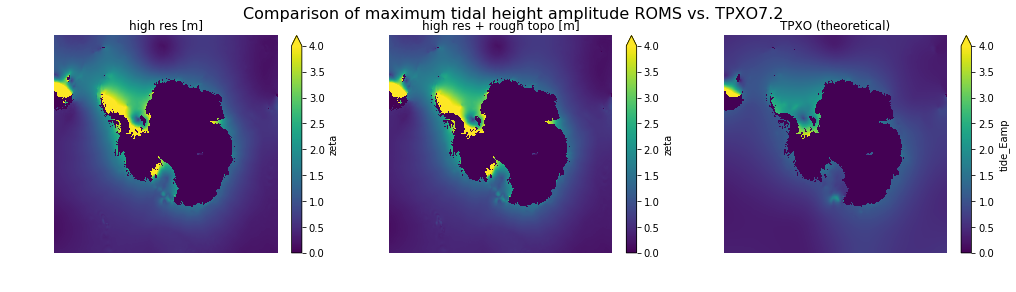

In [16]:
plot_max_ampl(ns_maxAmpl,'high res + rough topo',hr_maxAmpl,'high res')

### M2 O1 height amplitudes

In [17]:
ds_ns = grid_ttide(ds_ns,ds_ns,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


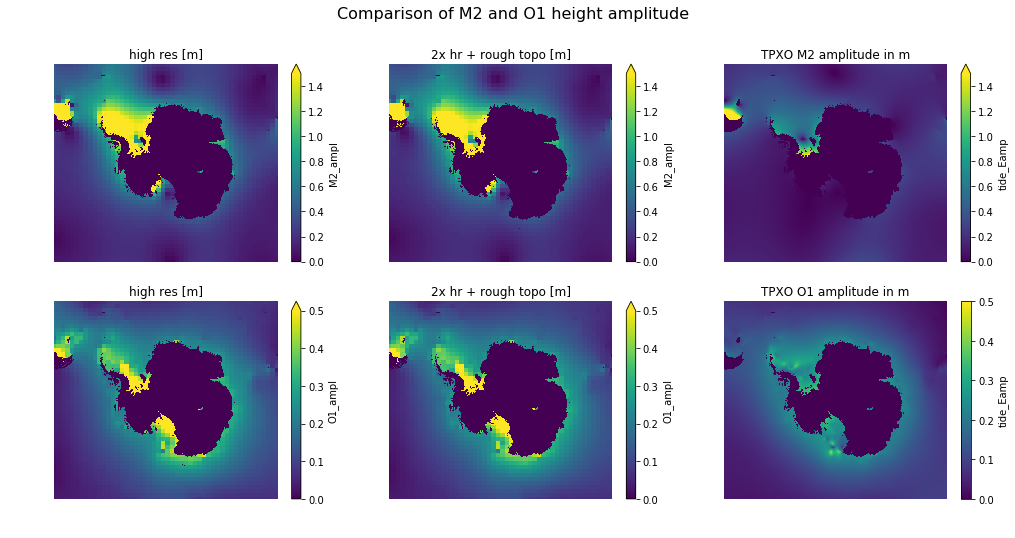

In [18]:
plot_M2O1(ds_ns,'2x hr + rough topo',ds_hr,'high res')

# Scaling tidal height amplitiude of forcing
Simple solution would be to scale down the Pamp amplitude of the forcing by simply setting a scaling factor in varinfo.dat. However we have have to think about a justification for that.
To determine a rough scaling factor, I compare the ratios between roms and tpxo of sping tide amplitude, M2 and K1.

### Determining the scaling factor

... so Roms spring tide is 1.55 times to big and needs to be scaled by 1/1.55 = 0.65. 

### Results:

In [19]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom5_scale','ocean_his_0002.nc')
ds_sc = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
sc_maxAmpl = ds_sc.zeta[:].max('ocean_time')-ds_sc.zeta[:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


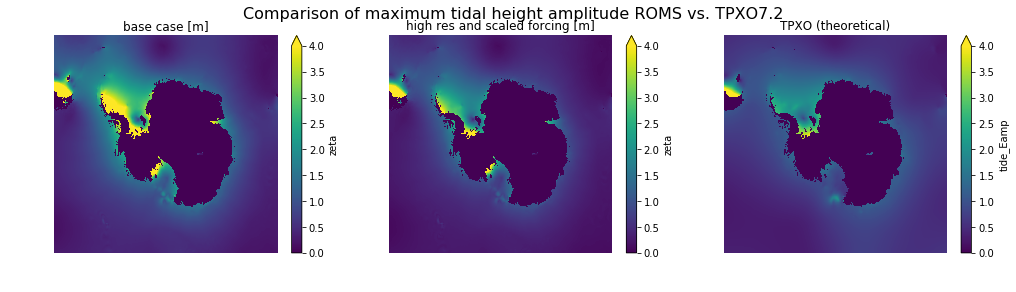

In [21]:
plot_max_ampl(sc_maxAmpl,'high res and scaled forcing',hr_maxAmpl,'base case')

### M2 O1 height amplitudes

In [22]:
ds_sc = grid_ttide(ds_sc,ds_sc,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


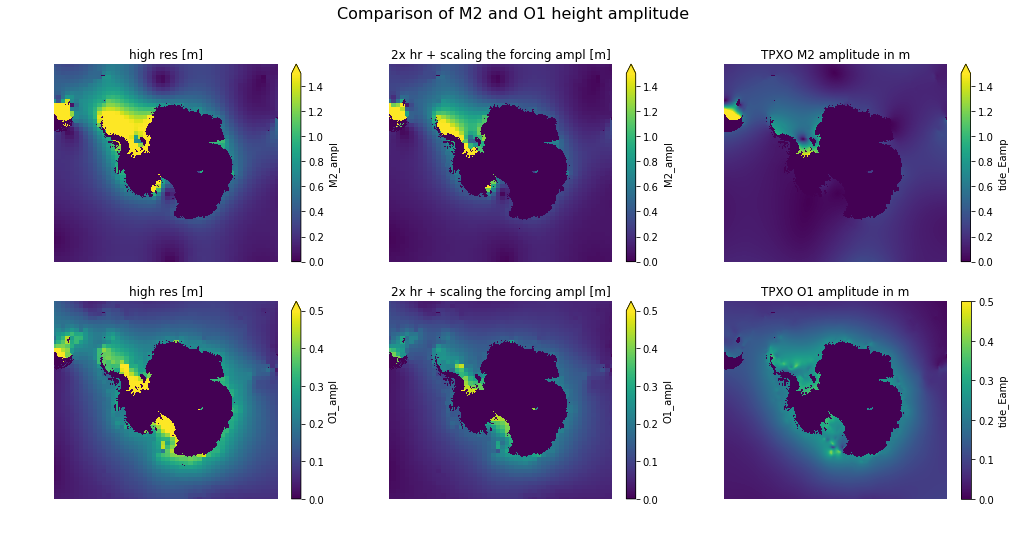

In [23]:
plot_M2O1(ds_sc,'2x hr + scaling the forcing ampl',ds_hr,'high res')

# Mask forcing south of 60S
Our forcing is already the reaction of a model to astronomical forcing. The kelvin waves on the shelf might be forced two times in our model. First by the deep ocean wave approaching the shelf and second by the prescribed tides on the shelf. By masking everything south of 60S and ramping full foring to 50S we hope to avoid the two sources of shelf tides.
### Generating the mask

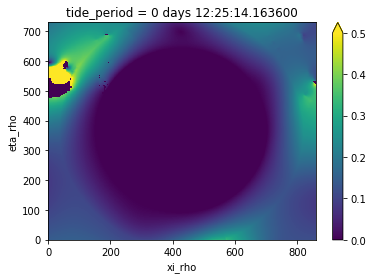

In [19]:
#mask tidal forcing
import xarray as xr
import os
import sys
import matplotlib.pyplot as plt

pott_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)

Pamp_tmp = pott_ds.tide_Pamp.where(grid_ds.lat_rho > -65 ,0.0)
scale = (grid_ds.lat_rho + 65.0)/10
Pamp_masked = Pamp_tmp.where((grid_ds.lat_rho < -65)|(grid_ds.lat_rho > -55),Pamp_tmp*scale)
plt.close()
Pamp_masked[0].plot(vmax=0.5)
plt.show()

### Results

In [20]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_65_0006.nc')
ds_tm_65 = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
tm_65_maxAmpl = ds_tm_65.zeta[336:].max('ocean_time')-ds_tm_65.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


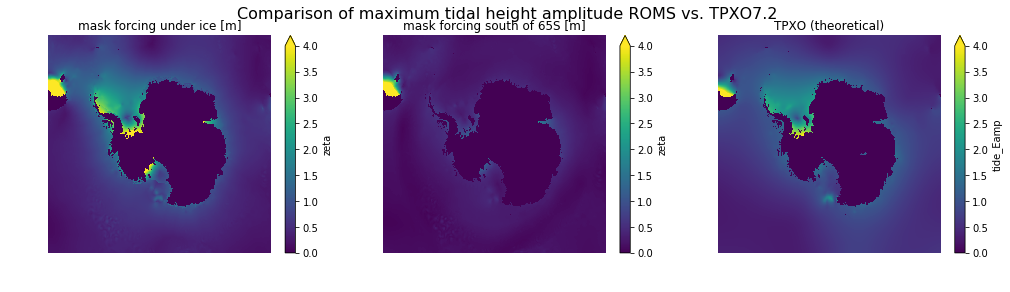

In [21]:
plot_max_ampl(tm_65_maxAmpl,'mask forcing south of 65S',tm_maxAmpl,'mask forcing under ice')

In [22]:
ds_tm_65 = grid_ttide(ds_tm_65,ds_tm_65,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


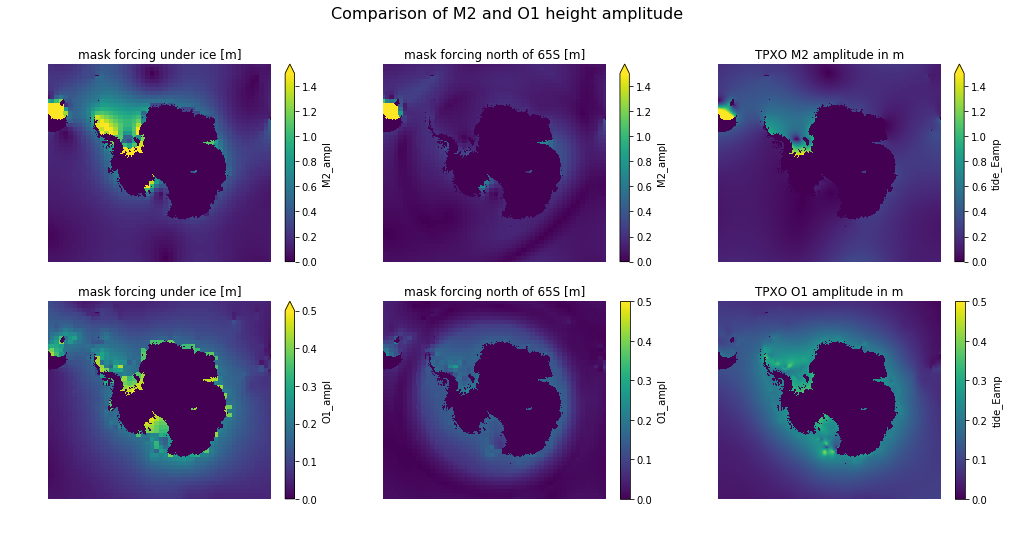

In [36]:
plot_M2O1(ds_tm_65,'mask forcing north of 65S',ds_tm,'mask forcing under ice')

... M2 seems to be reuced big time, however O1 is still to big where the coastline is rough. Next try just masking onshelf areas with ramping to deep.

# Mask forcing on shelf
Since masking 60S is to much and masking just ice shelves is to less, I try masking the shallow areas with smooth transition.We can argue with the non linear shallow water dynamics.
### Generating the mask

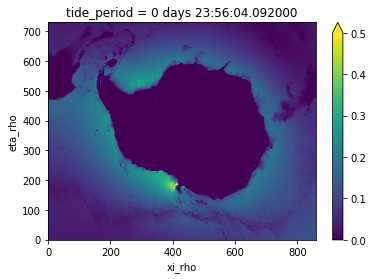

In [24]:
Pamp_tmp = pott_ds.tide_Pamp.where((grid_ds.h > 1000),0.0)
Pamp_tmp = Pamp_tmp.where((grid_ds.zice==0.0),0.0)
scale = (grid_ds.h - 1000)/3000
Pamp_masked = Pamp_tmp.where((grid_ds.h < 1000 )|(grid_ds.h > 4000),Pamp_tmp*scale)
plt.close()
Pamp_masked[4].plot(vmax=0.5)
plt.show()

### Results

In [7]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_shelf_0006.nc')
ds_tm_shelf = xr.open_mfdataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
tm_shelf_maxAmpl = ds_tm_shelf.zeta[336:].max('ocean_time')-ds_tm_shelf.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


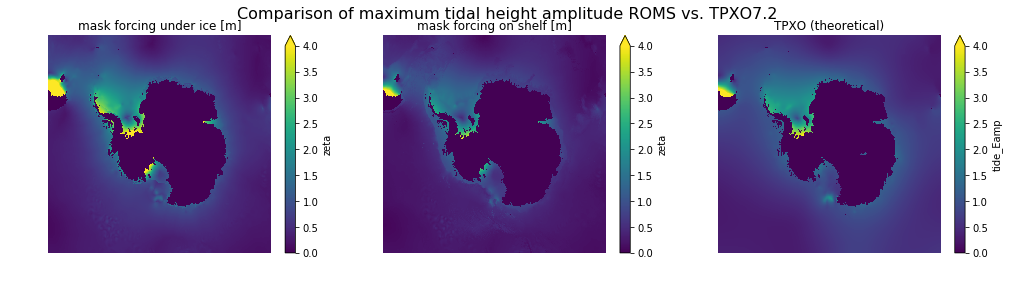

In [26]:
plot_max_ampl(tm_shelf_maxAmpl,'mask forcing on shelf',tm_maxAmpl,'mask forcing under ice')

In [24]:
%%time
ds_tm_shelf = grid_ttide(ds_tm_shelf,ds_tm_shelf,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land
CPU times: user 1h 35min 17s, sys: 2min 55s, total: 1h 38min 12s
Wall time: 17min 22s


... Just a bit smoother transition between forcing and no forcing.
### Smoothing the mask edge

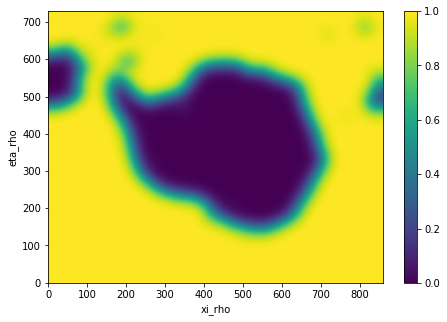

In [27]:
from scipy.ndimage.filters import gaussian_filter, uniform_filter
pott_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)

mask_tmp = grid_ds.mask_rho.where((grid_ds.zice == 0),0.0)
mask_tmp = mask_tmp.where(grid_ds.h > 1000,0.0)
mask_tmp.values = gaussian_filter(mask_tmp,20)

plt.close()
mask_tmp.plot(size=5)
plt.show()

### Results

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


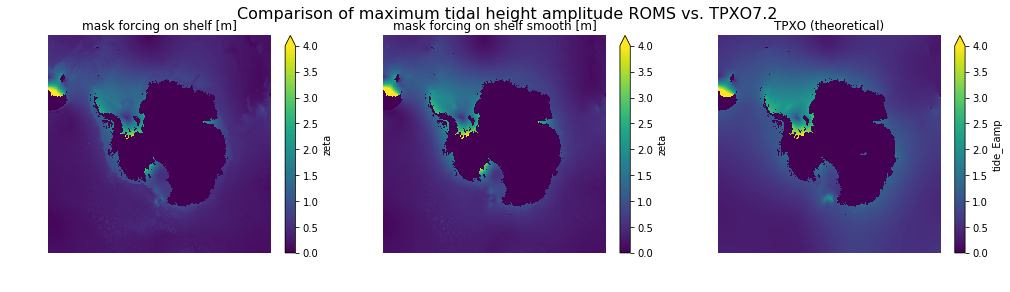

CPU times: user 30.2 s, sys: 16.5 s, total: 46.7 s
Wall time: 34.2 s


In [11]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_smooth_0006.nc')
ds_tm_smooth = xr.open_mfdataset(file_path,chunks={'xi_rho':100,'eta_rho':100})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
tm_smooth_maxAmpl = ds_tm_smooth.zeta[336:].max('ocean_time')-ds_tm_smooth.zeta[336:].mean('ocean_time')
# plot max ampl
plot_max_ampl(tm_smooth_maxAmpl,'mask forcing on shelf smooth',tm_shelf_maxAmpl,'mask forcing on shelf')

In [25]:
%%time
ds_tm_smooth =grid_ttide(ds_tm_smooth,ds_tm_smooth,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land
CPU times: user 1h 33min 37s, sys: 2min 41s, total: 1h 36min 18s
Wall time: 17min 32s


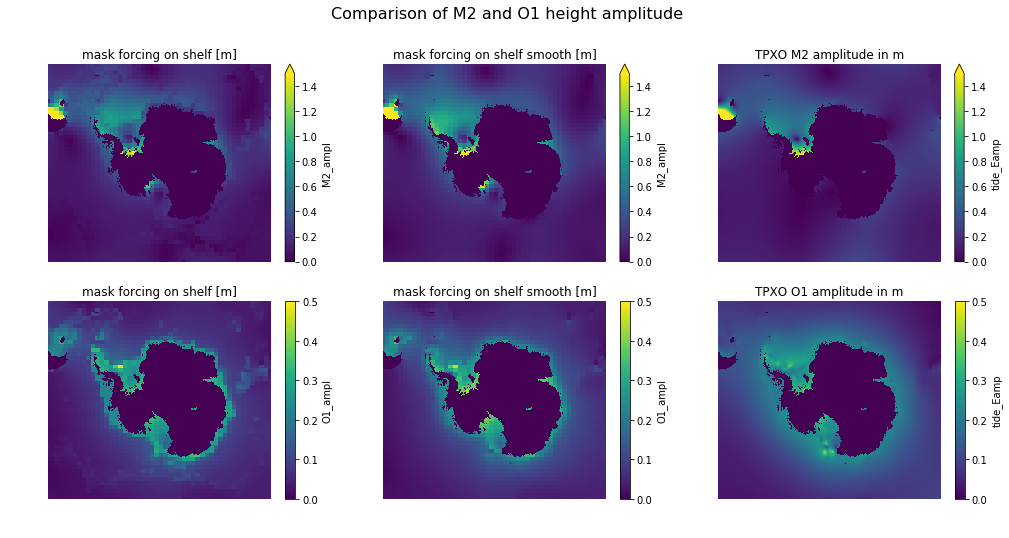

In [37]:
plot_M2O1(ds_tm_smooth,'mask forcing on shelf smooth',ds_tm_shelf,'mask forcing on shelf')

## Adjusting the mask edge location
Since O1 still shows this jump in amplitude, I push the mask edge further away from the shelf.

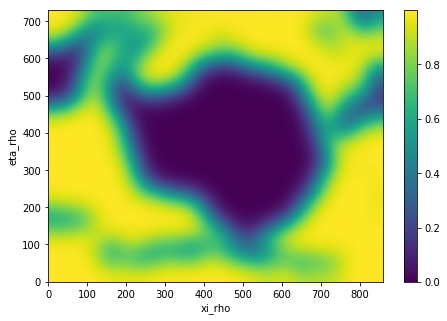

In [22]:
from scipy.ndimage.filters import gaussian_filter, uniform_filter
pott_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)

mask_tmp = grid_ds.mask_rho.where((grid_ds.zice == 0),0.0)
mask_tmp = mask_tmp.where(grid_ds.h > 3000,0.0)
mask_tmp.values = gaussian_filter(mask_tmp,30)

plt.close()
mask_tmp.plot(size=5)
plt.show()

In [26]:
out_path = os.path.join(pott_path,os.pardir,'waom10_ptds_tm_smooth_deep.nc')
pott_ds['tide_Pamp']=pott_ds.tide_Pamp*mask_tmp
pott_ds.to_netcdf(out_path,'w')

### Results

In [3]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_tidal_mask','ocean_his_tm_smooth_deep_0006.nc')
ds_tm_smooth_deep = xr.open_mfdataset(file_path,chunks={'xi_rho':100,'eta_rho':100})

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


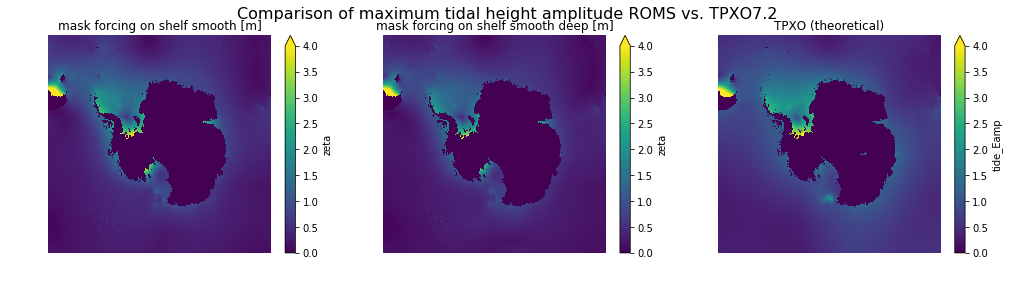

In [27]:
# calculate maximum anomaly of the free surface height compared to the 14 day mean
tm_smooth_deep_maxAmpl = ds_tm_smooth_deep.zeta[336:].max('ocean_time')-ds_tm_smooth_deep.zeta[336:].mean('ocean_time')
# plot max ampl
plot_max_ampl(tm_smooth_deep_maxAmpl,'mask forcing on shelf smooth deep',tm_smooth_maxAmpl,'mask forcing on shelf smooth')

In [ ]:
%%time
ds_tm_smooth_deep = grid_ttide(ds_tm_smooth_deep,ds_tm_smooth_deep)

setting up the new fields  ['amp', 'amp_err', 'phase', 'phase_err']  for  ['O1', 'M2']
applying t_tide to every  50 th cell


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

In [ ]:
plot_M2O1(ds_tm_smooth_deep,'mask forcing on shelf smooth smooth deep',ds_tm_smooth,'mask forcing on shelf smooth')

In [ ]:
def plot_M2O1_diff(ds_case,case_str,vmin=-0.10,vmax=0.10):
    
    plt.close('all')
    fig,axes = plt.subplots(ncols=2,nrows=3,figsize=(15,15))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
    
    fig.suptitle(case_str+'\n M2 and O1 height amplitude difference to TPXO',fontsize=16)
     
    M2_diff = ds_case.M2_amp-dsf.tide_Eamp[0]
    O1_diff = ds_case.O1_amp-dsf.tide_Eamp[5]
    
    M2_diff_rel = abs(ds_case.M2_amp-dsf.tide_Eamp[0])/dsf.tide_Eamp[0]
    O1_diff_rel = abs(ds_case.O1_amp-dsf.tide_Eamp[5])/dsf.tide_Eamp[5]
    
    M2_diff.plot(ax=ax1,cmap=plt.cm.bwr,vmin=vmin,vmax=vmax)
    ax1.set_title('M2 ampl diff [m]')
    
    O1_diff.plot(ax=ax2,cmap=plt.cm.bwr,vmin=vmin,vmax=vmax)
    ax2.set_title('O1 ampl diff [m]')
    
    ds_case.M2_amp_err.plot(ax=ax3)
    ax3.set_title('M2 ampl error [m]')
    
    ds_case.O1_amp_err.plot(ax=ax4)
    ax4.set_title('O1 ampl error [m]')
    
    M2_diff_rel.fillna(0).plot(ax=ax5,vmin=0,vmax=1)
    ax5.set_title('M2 ampl relative diff')
    
    O1_diff_rel.fillna(0).plot(ax=ax6,vmin=0,vmax=1)
    ax6.set_title('O1 ampl relative diff')
    
    
    for ax in axes.flatten():
        ax.axis("off")
        ax.set_aspect('equal')
    
    plt.show()

In [ ]:
plot_M2O1_diff(ds_tm_smooth_deep,'mask_shelf_deep_smooth')

# Drag revisited tm + 10xCd

In [4]:
#load roms output that has been forced with this tpxo file
file_path = os.path.join(os.environ.get('rawdir'),'waom10_Cd','ocean_his_x10Cd_0006.nc')
Cd = xr.open_mfdataset(file_path,chunks={'xi_rho':100,'eta_rho':100})

In [ ]:
Cd = ta.grid_ttide(Cd,Cd)

In [ ]:
plot_M2O1_diff(Cd,'10xCd')

# Phase information
Lets check if the phases agree with TPXO.

In [68]:
# load tpxo forcing phase with base date 2007 01 01 00:00:00
tpxo_2007_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_data','waom10_tds_2007_hack.nc')
dsf_2007 = xr.open_mfdataset(tpxo_2007_path)

In [69]:
#load roms output that has been forced with this tpxo file
file_path = os.path.join(os.environ.get('rawdir'),'waom10','ocean_his_0006.nc')
ds_2007 = xr.open_mfdataset(file_path,chunks={'xi_rho':100,'eta_rho':100})

In [70]:
#select the appropriate time frame from this roms data
ds_sel = ds_2007.sel(ocean_time=slice('2012-01-01T00:00:00','2012-01-28T23:00:00'))

In [76]:
# define plotting function
def plot_M2O1_phase(case_ds,case_str):
    plt.close('all')
    fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(17,8))
    ax1,ax2,ax3,ax4 = axes.flatten()
    fig.suptitle('Comparison of M2 and O1 height phase',fontsize=16)

    case_ds.M2_phase.fillna(0).plot(ax=ax1)
    ax1.set_title(case_str +' [deg]')
    ax1.axis('off')

    dsf_2007.tide_Pphase[0].plot(ax=ax2)
    ax2.set_title('TPXO M2 phase in deg')
    ax2.axis('off')
    
    case_ds.O1_phase.fillna(0).plot(ax=ax3)
    ax3.set_title(case_str+' [deg]')
    ax3.axis('off')

    dsf_2007.tide_Pphase[5].plot(ax=ax4)
    ax4.set_title('TPXO O1 phase in deg')
    ax4.axis('off')

    for ax in axes.flatten():
        ax.set_aspect('equal')
        ax.axis("off")
        
    plt.show()

In [1]:
%%time
# perform tidal analysis
ds_phase = grid_ttide(ds_sel,ds_sel,50)

NameError: name 'grid_ttide' is not defined

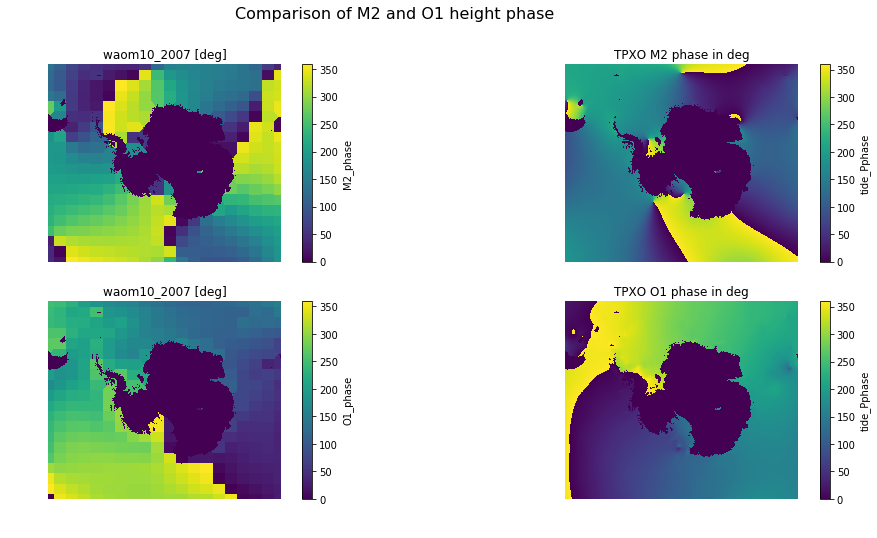

In [80]:
# plot roms phase info against tpxo
plot_M2O1_phase(ds_phase,"waom10_2007")